# Simple estimating of polarized power spectrum

This example shows how to combine visibilities to form pseudo-Stokes and estimate the power spectrum from a set of data files using an Optimal Quadratic Estimator (OQE) approach.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyuvdata
import pstokes as st
import pspecdata as pd
import pspecbeam as pb
import hera_pspec as hp

The input can be specified as miriad files or UVData objects. The miriad files are internally converted to UVData objects if the inputs are given as miriad files.

This example uses miriad files with xx and yy polarizations as inputs to form Stokes I and Q.

In [2]:
dset1 = 'data/zen.all.xx.LST.1.06964.uvA' # xx miriad file
dset2 = 'data/zen.all.yy.LST.1.06964.uvA' # yy miriad file

The construct_stokes function validates the input datasets to ensure that the correct datasets are specified to form the pseudo stokes visibilities and calls the combine_pol function. The combine_pol function combines the visibilities to form the pseudo stokes visibilities and change metadata of the UVData object accordingly for example the flags, polarization, history and nsamples.

In [3]:
uvdI = st.construct_pstokes(dset1=dset1, dset2=dset2, pstokes='I')
uvdQ = st.construct_pstokes(dset1=dset1, dset2=dset2, pstokes='Q')

## Plotting pseudo-Stokes I and Q visibilties

divide by zero encountered in log10
divide by zero encountered in log10


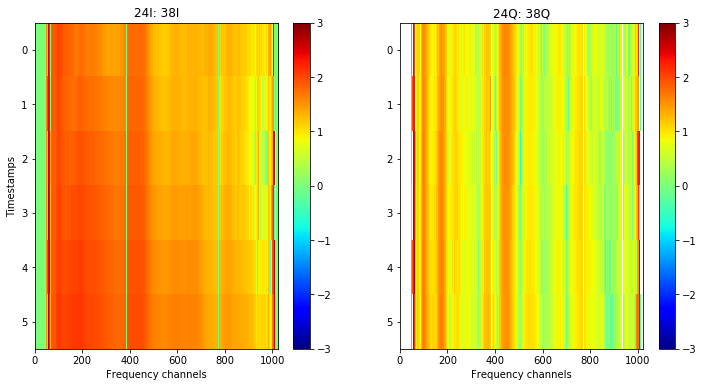

In [4]:
dataI = uvdI.get_data(24,38)
dataQ = uvdQ.get_data(24,38)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('24I: 38I')
plt.imshow(np.log10(np.abs(dataI)),aspect='auto',vmin=-3,vmax=3,cmap='jet')
plt.colorbar()
plt.ylabel('Timestamps')
plt.xlabel('Frequency channels')

plt.subplot(122)
plt.title('24Q: 38Q')
plt.imshow(np.log10(np.abs(dataQ)),aspect='auto',vmin=-3,vmax=3,cmap='jet')
plt.colorbar()
plt.xlabel('Frequency channels')

plt.subplots_adjust(hspace=0.3)

## Estimating power spectrum from pseudo-Stokes I 

Instantiate a Cosmo Conversions object
we will need this cosmology to put the power spectra into cosmological units and estimated pseudo-Stokes I power spectrum similar to ipython notebook in hera_pspec/examples.

In [5]:
cosmo = hp.conversions.Cosmo_Conversions()
print cosmo

Cosmo_Conversions object at <0x1047cb790>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


In [6]:
# List of beamfile to load. This is a healpix map.
beamfile = '../hera_pspec/data/NF_HERA_Beams.beamfits'

# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

In [7]:
# slide the time axis of uvd by one integration
uvd1 = uvdI.select(times=np.unique(uvdI.time_array)[:-1:2], inplace=False)
uvd2 = uvdI.select(times=np.unique(uvdI.time_array)[1::2], inplace=False)
# Create a new PSpecData object, and don't forget to feed the beam object
ds = pd.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [8]:
# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvdI.freq_array))

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd1.data_array *= Jy_to_mK[None, None, :, None]
uvd2.data_array *= Jy_to_mK[None, None, :, None]

# changeunits of UVData objects
uvd1.vis_units = 'mK'
uvd2.vis_units = 'mK'

In [9]:
# Because the LST integrations are offset by more than ~15 seconds we will get a warning
# but this is okay b/c it is still **significantly** less than the beam-crossing time and we are using short
# baselines...

# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)

In [10]:
# Specify which baselines to include
baselines = [(24,25), (37,38), (38,39)]

In [11]:
# we will use the baselines list to produce 3 power spectra
# whose data will be drawn from the dsets[0] and dsets[1]
# across two spectral windows with identity weighting and a blackman-harris taper
uvp = ds.pspec(baselines, baselines, (0, 1), pols=[('pI', 'pI')], spw_ranges=[(300, 400), (600,721)], input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (300, 400)

Setting polarization pair: ['pI', 'pI']

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: ('I', 'I')
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: ('I', 'I')
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 39), (38, 39))
pol: ('I', 'I')
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (600, 721)

Setting polarization pair: ['pI', 'pI']

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: ('I', 'I')
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: ('I', 'I')
  Setting w

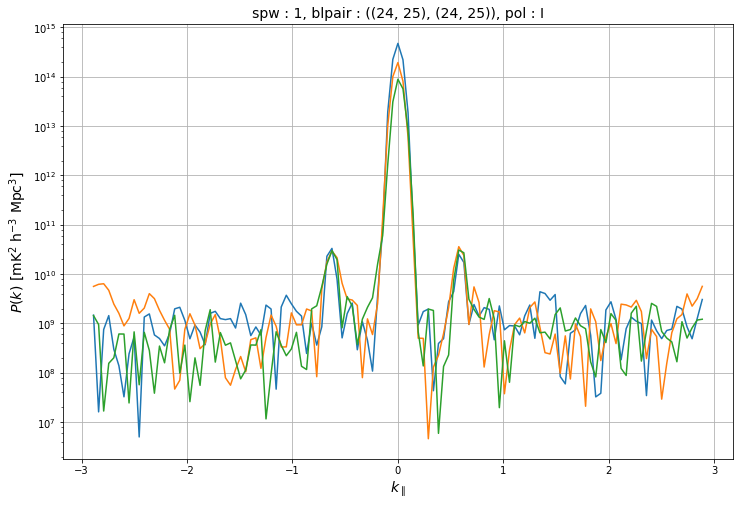

In [12]:
# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (24,25))
# uvspec and pyuvdata pols definition need to be fixed, as a hack, we used 'xx' as keyword 
# to store the pseudo-Stokes I power spectra values
key = (spw, blp, 'xx') # hack needs to be fixed in pyuvdata
key1 = (spw, blp, 'I')
dlys = uvp.get_dlys(spw) * 1e9
kpls = uvp.get_kparas(spw) 
power = np.abs(np.real(uvp.get_data(key)))

p1 = ax.plot(kpls, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_{\parallel}$", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key1), fontsize=14)

## Estimating power spectrum from pseudo-Stokes Q

In this example, we estimate the power spectra from pseudo-Stokes Q visibilities. The beam normalization development is still in progress. Therefore as an example we computed the normalization similar to https://arxiv.org/pdf/1802.04151.pdf.

In [13]:
# reading mueller matrix (same as Saul's paper)
mueller = np.load('/Users/Ridhima/Documents/hera/beams/HERA_NicCST_nside128_nfreq201_100-200_10MHz_mueller.npy')
mQ = mueller[:,:,1,1]
nside=128
Omega_P = np.sum(mQ,axis=-1) * np.pi/(3*nside**2)
Omega_PP = np.sum(mQ**2,axis=-1) * np.pi/(3*nside**2)
print ('Omega_P: ',Omega_P, ' Omega_PP: ', Omega_PP)

('Omega_P: ', array([0.03597151, 0.03084971, 0.02685263, 0.02342032, 0.01941178,
       0.01746981, 0.01730298, 0.01472498, 0.01269876, 0.01277114,
       0.01394258]), ' Omega_PP: ', array([0.00893583, 0.00769852, 0.00644321, 0.00578867, 0.00478384,
       0.0042155 , 0.00420799, 0.00360696, 0.00307701, 0.00306829,
       0.0032366 ]))


In [14]:
# the beam model in the file spans 100-200 MHz with 10 MHz frequency spacing
beamfreqs = np.linspace(100e6,200e6,11)

# constructing dictionary for the beam scalars to feed into the Custom Class of the Beam object
OmegaP={'Q': Omega_P}
OmegaPP={'Q': Omega_PP}
custom_beam = hp.PSpecBeamFromArray(OmegaP=OmegaP,OmegaPP=OmegaPP, beam_freqs=beamfreqs)

In [15]:
# slide the time axis of uvd by one integration
uvd1 = uvdQ.select(times=np.unique(uvdQ.time_array)[:-1:2], inplace=False)
uvd2 = uvdQ.select(times=np.unique(uvdQ.time_array)[1::2], inplace=False)
# Create a new PSpecData object, and don't forget to feed the beam object
ds = pd.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=custom_beam)

In [16]:
# converting to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvdI.freq_array))

uvd1.data_array *= Jy_to_mK[None, None, :, None]
uvd2.data_array *= Jy_to_mK[None, None, :, None]

uvd1.vis_units = 'mK'
uvd2.vis_units = 'mK'

In [17]:
ds.rephase_to_dset(0)
uvpQ = ds.pspec(baselines, baselines, (0, 1), pols=[('pQ', 'pQ')], spw_ranges=[(300, 400), (600,721)], input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (300, 400)

Setting polarization pair: ['pQ', 'pQ']

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: ('Q', 'Q')
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: ('Q', 'Q')
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 39), (38, 39))
pol: ('Q', 'Q')
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (600, 721)

Setting polarization pair: ['pQ', 'pQ']

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: ('Q', 'Q')
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: ('Q', 'Q')
  Setting w